In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

In [3]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=2000
LATENT_DIM=512
IMAGE_SIZE=64

In [4]:
try:
  os.mkdir('/tmp/anime')
except OSError:
  pass

data_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = '/tmp/anime/'
urllib.request.urlretrieve(data_url, data_file_name)

zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [5]:
def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0  
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

In [6]:
paths = get_dataset_slice_paths("/tmp/anime/images/")

random.shuffle(paths)

paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 26
number of batches in the validation set: 7


In [7]:
def display_faces(dataset, size=9):
  '''Takes a sample from a dataset batch and plots it in a grid.'''
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(5, 5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (64,64,3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Displays a row of images.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  '''Displays input and predicted images.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))

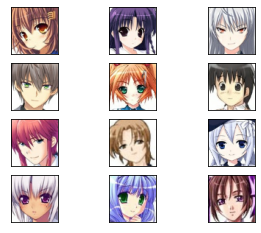

In [8]:
display_faces(validation_dataset, size=12)

In [9]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output
    
    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """
    mu, sigma = inputs 
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    z = mu + tf.exp(0.5 * sigma) * epsilon
    return  z

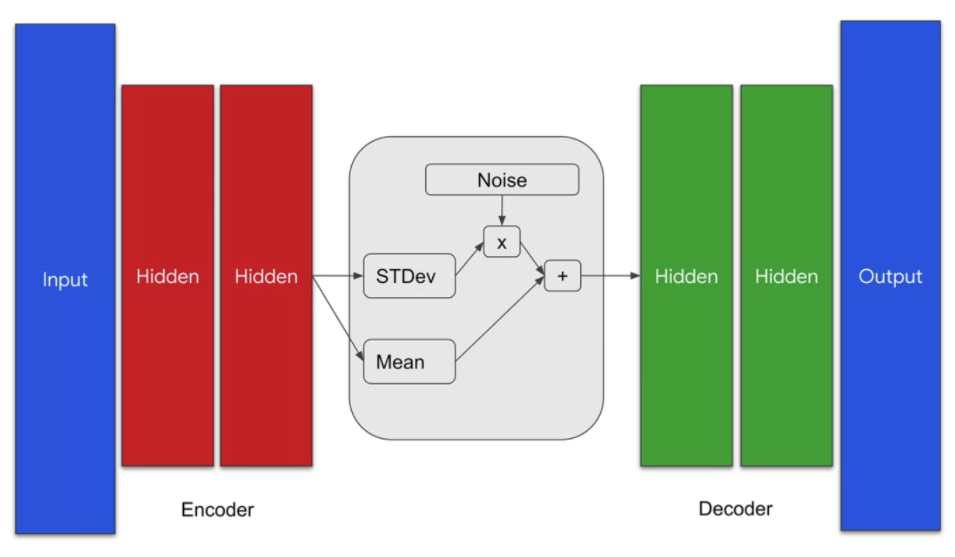

In [10]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_3.shape -- shape of the features before flattening
  """

  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  

  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)
  x = tf.keras.layers.BatchNormalization()(x)


  x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv3")(x) 

  batch_3 = tf.keras.layers.BatchNormalization()(x)   
  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_3)

  x = tf.keras.layers.Dense(1024, activation='relu', name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)
  
  return mu, sigma, batch_3.shape

In [11]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """
  inputs = tf.keras.layers.Input(shape=input_shape)
  mu, sigma, conv_shape =  encoder_layers(inputs, latent_dim=LATENT_DIM)
  z = Sampling()((mu, sigma))
  model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

  model.summary()
  return model, conv_shape

In [12]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_1")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_12")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x) 



  x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)

  return x

In [13]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """

  inputs = tf.keras.layers.Input(shape=(latent_dim,))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs, outputs)

  model.summary()
  return model

In [14]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

In [15]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  inputs = tf.keras.layers.Input(shape=input_shape)

  mu, sigma, z = encoder(inputs)
  
  reconstructed = decoder(z)

  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)
  
  return model

In [16]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  
  return encoder, decoder, vae

In [17]:
encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encode_conv1 (Conv2D)          (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['encode_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 encode_conv2 (Conv2D)          (None, 16, 16, 64)   18496       ['batch_normalization[0][0]']

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [19]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

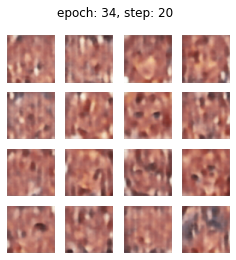

Epoch: 34 step: 20 mean loss = 340.416
Epoch: 34 step: 21 mean loss = 340.2555
Epoch: 34 step: 22 mean loss = 340.09317
Epoch: 34 step: 23 mean loss = 339.92972
Epoch: 34 step: 24 mean loss = 339.76202
Epoch: 34 step: 25 mean loss = 339.59628


In [20]:
#increase the number of epochs until loss comes down pto about 300. I have trained the model foe 34 epochs only
epochs = 35

random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  for step, x_batch_train in enumerate(training_dataset):
    with tf.GradientTape() as tape:
      reconstructed = vae(x_batch_train)
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = mse_loss(flattened_inputs, flattened_outputs) * 64 * 64 * 3
      loss += sum(vae.losses) 

      

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    
    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

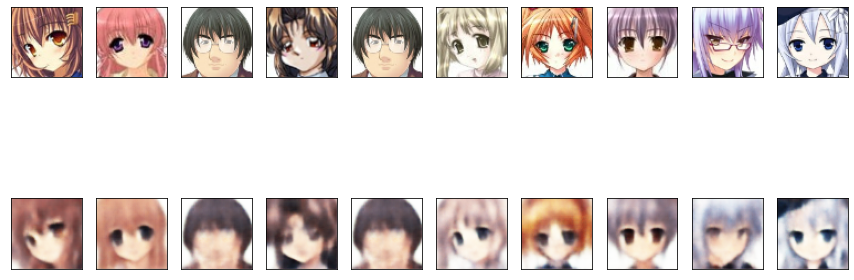

In [21]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

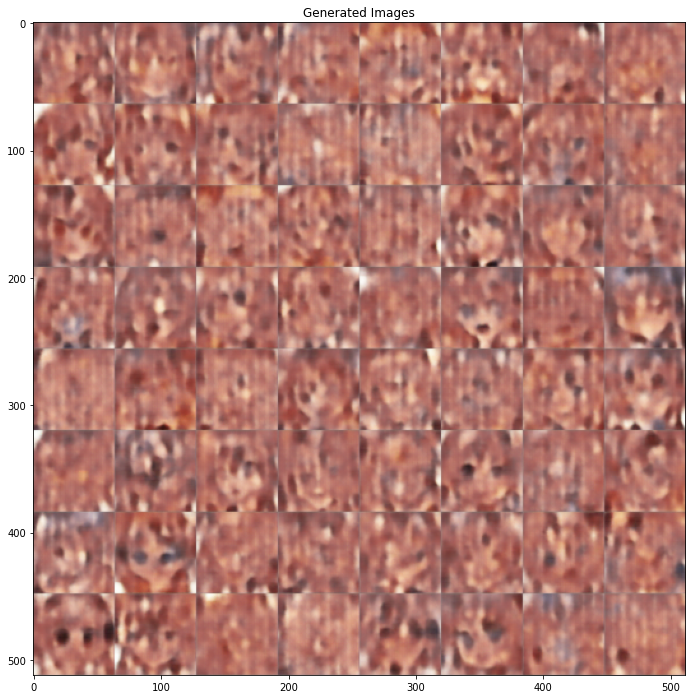

In [23]:
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[64, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')

In [24]:
vae.save("anime.h5")